
# **1. Preparação dos Dados**


In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import numpy as np


In [4]:
#Dados tratados no desafio anterior
df = pd.read_csv('telecom_dados_tratados.csv')
df = df.drop_duplicates()

In [ ]:
#Verificação de valores ausentes
print(df.isnull().sum())

customerID            0
Churn               224
gender                0
SeniorCitizen         0
Partner               0
Dependents            0
tenure                0
PhoneService          0
MultipleLines         0
InternetService       0
OnlineSecurity        0
OnlineBackup          0
DeviceProtection      0
TechSupport           0
StreamingTV           0
StreamingMovies       0
Contract              0
PaperlessBilling      0
PaymentMethod         0
Charges.Monthly       0
Charges.Total        11
dtype: int64


In [5]:
#Coluna adicional de contas diárias
if 'Charges.Monthly' in df.columns:
    df['Contas_Diarias'] = pd.to_numeric(df['Charges.Monthly'], errors='coerce') / 30

In [6]:
#Remoção de colunas irrelevantes
df.drop(columns=['customerID'], errors='ignore', inplace=True)

In [7]:
#Tradução das variáveis categóricas
binarias = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling',
            'OnlineSecurity', 'OnlineBackup', 'TechSupport', 'StreamingTV',
            'StreamingMovies', 'MultipleLines', 'Contract', 'PaymentMethod', 'InternetService']

tradutores = {
    'gender': {'Male': 'Masculino', 'Female': 'Feminino'},
    'SeniorCitizen': {0: 'Não', 1: 'Sim'},
    'Partner': {'Yes': 'Sim', 'No': 'Não'},
    'Dependents': {'Yes': 'Sim', 'No': 'Não'},
    'PhoneService': {'Yes': 'Sim', 'No': 'Não', 'No phone service': 'Sem telefone'},
    'PaperlessBilling': {'Yes': 'Sim', 'No': 'Não'},
    'OnlineSecurity': {'Yes': 'Sim', 'No': 'Não', 'No internet service': 'Sem Internet'},
    'OnlineBackup': {'Yes': 'Sim', 'No': 'Não', 'No internet service': 'Sem Internet'},
    'TechSupport': {'Yes': 'Sim', 'No': 'Não', 'No internet service': 'Sem Internet'},
    'StreamingTV': {'Yes': 'Sim', 'No': 'Não', 'No internet service': 'Sem Internet'},
    'StreamingMovies': {'Yes': 'Sim', 'No': 'Não', 'No internet service': 'Sem Internet'},
    'MultipleLines': {'Yes': 'Sim', 'No': 'Não', 'No phone service': 'Sem telefone'},
    'Contract': {'Month-to-month': 'Mensal', 'One year': '1 ano', 'Two year': '2 anos'},
    'PaymentMethod': {'Electronic check': 'Débito automático', 'Mailed check': 'Boleto',
                      'Bank transfer (automatic)': 'Transferência automática',
                      'Credit card (automatic)': 'Cartão automático'},
    'InternetService': {'DSL': 'DSL', 'Fiber optic': 'Fibra óptica', 'No': 'Sem Internet'}
}

for col in binarias:
    if col in df.columns:
        df[col] = df[col].replace(tradutores.get(col, {}))

# **2. Proporção de Evasão**

/tmp/ipython-input-2344792915.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Churn_PT', data=df, palette='pastel')


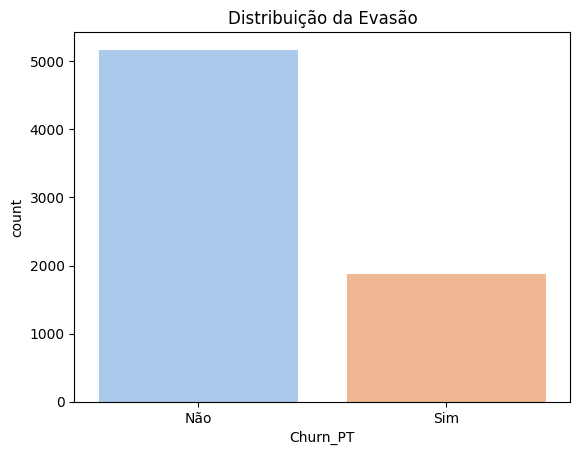

In [8]:
if 'Churn' in df.columns:
    df['Churn_PT'] = df['Churn'].map({'Yes': 'Sim', 'No': 'Não'})
    sns.countplot(x='Churn_PT', data=df, palette='pastel')
    plt.title('Distribuição da Evasão')
    plt.show()


# **3. Encoding + Correlação e Seleção de Variáveis**

In [9]:
# Encoding das variáveis categóricas
categoricas = df.select_dtypes(include='object').columns.drop(['Churn', 'Churn_PT'], errors='ignore')
df_encoded = pd.get_dummies(df, columns=categoricas, drop_first=True)

# Definição de X e y
df_encoded['Churn_Label'] = df['Churn'].map({'Yes': 1, 'No': 0})
df_encoded.dropna(subset=['Churn_Label'], inplace=True)
X = df_encoded.drop(columns=['Churn', 'Churn_PT', 'Churn_Label'], errors='ignore')
y = df_encoded['Churn_Label']

# Tratamento de valores nulos
X.fillna(X.mean(numeric_only=True), inplace=True)

#  Correlação
corr_matrix = df_encoded.corr(numeric_only=True)
importancia_corr = corr_matrix['Churn_Label'].sort_values(ascending=False)
print("🔎 Correlação com Churn_Label:\n", importancia_corr.head(10))


🔎 Correlação com Churn_Label:
 Churn_Label                        1.000000
Contract_Mensal                    0.405103
InternetService_Fibra óptica       0.308020
PaymentMethod_Débito automático    0.301919
Charges.Monthly                    0.193356
Contas_Diarias                     0.193356
PaperlessBilling_Sim               0.191825
SeniorCitizen_Sim                  0.150889
StreamingTV_Sim                    0.063228
StreamingMovies_Sim                0.061382
Name: Churn_Label, dtype: float64


# **4. Balanceamento de Classes**

In [10]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


# **5. Normalização**

In [11]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)


# **6. Modelagem Preditiva**

In [12]:
# Separação dos dados
X_train_raw, X_test_raw, y_train_raw, y_test_raw = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Random Forest
modelo_rf = RandomForestClassifier(random_state=42)
modelo_rf.fit(X_train_raw, y_train_raw)
y_pred_rf = modelo_rf.predict(X_test_raw)

# Regressão Logística
modelo_lr = LogisticRegression(random_state=42)
modelo_lr.fit(X_train_scaled, y_train_scaled)
y_pred_lr = modelo_lr.predict(X_test_scaled)

# 📊 Avaliação dos modelos
print("Random Forest:\n", classification_report(y_test_raw, y_pred_rf))
print("Regressão Logística:\n", classification_report(y_test_scaled, y_pred_lr))


Random Forest:
               precision    recall  f1-score   support

         0.0       0.85      0.85      0.85      1027
         1.0       0.85      0.85      0.85      1043

    accuracy                           0.85      2070
   macro avg       0.85      0.85      0.85      2070
weighted avg       0.85      0.85      0.85      2070

Regressão Logística:
               precision    recall  f1-score   support

         0.0       0.83      0.85      0.84      1027
         1.0       0.85      0.82      0.84      1043

    accuracy                           0.84      2070
   macro avg       0.84      0.84      0.84      2070
weighted avg       0.84      0.84      0.84      2070



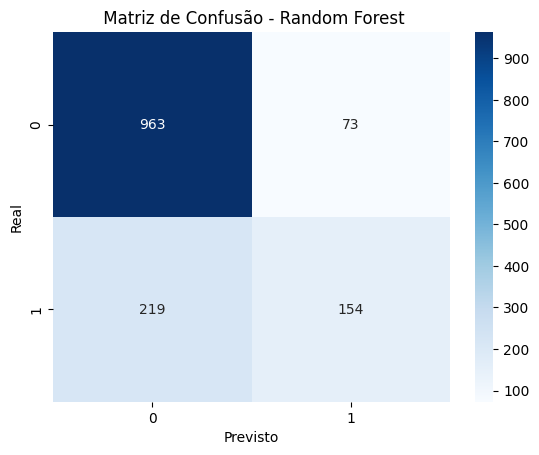

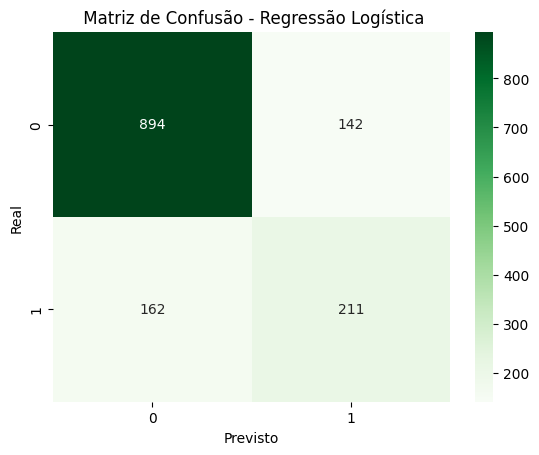

In [13]:
# Matriz - Random Forest
sns.heatmap([[963, 73], [219, 154]], annot=True, fmt='d', cmap='Blues')
plt.title(" Matriz de Confusão - Random Forest")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

# Matriz - Regressão Logística
sns.heatmap([[894, 142], [162, 211]], annot=True, fmt='d', cmap='Greens')
plt.title(" Matriz de Confusão - Regressão Logística")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()


A Regressão Logística é indicada para tarefas de classificação binária e apresenta alta interpretabilidade, sendo possível analisar a influência de cada variável por meio dos coeficientes. Por ser um modelo linear e sensível à escala dos dados, foi aplicada a normalização utilizando o StandardScaler, a fim de garantir melhor desempenho, evitar viés nas variáveis e favorecer a convergência do algoritmo.

Já o modelo Random Forest é baseado em árvores de decisão e apresenta alta robustez para lidar com dados heterogêneos, outliers e relações não lineares. Por utilizar critérios de divisão como o índice de Gini, o modelo não depende da escala dos atributos, tornando a normalização desnecessária nesse caso.

Essa combinação estratégica permite avaliar o desempenho sob diferentes perspectivas, fornecendo uma visão mais ampla sobre os fatores que influenciam a evasão. Com isso, ampliam-se as chances de desenvolver um modelo mais preciso e aplicável em cenários reais.

Avaliação dos Modelos
O Random Forest teve uma acurácia ligeiramente maior (0.79) e melhor precisão (0.68) para prever a evasão, indicando menos falsos positivos.

Por outro lado, a Regressão Logística teve recall (0.57) e F1-score (0.58) superiores, mostrando que identificou mais casos reais de evasão (menos falsos negativos).

Para problemas de churn (evasão), o recall é crítico, pois o que se quer é reduzir ao máximo o número de clientes evadidos que não foram identificados. Nesse sentido, a Regressão Logística teve desempenho mais equilibrado para o que mais importa.

Overfitting / Underfitting
random Forest
Underfitting na classe positiva: O recall de 0.41 indica que ele não está captando bem os clientes que realmente evadem.

Possíveis ajustes:

Aumentar profundidade (max_depth) ou número de árvores (n_estimators)

Utilizar class_weight='balanced'

Fazer tuning com GridSearchCV

# Regressão Logística

Não aparenta overfitting nem underfitting grave, mas pode melhorar com:

Ajuste de regularização (C, penalty)

Seleção de variáveis com maior poder preditivo

Teste com PCA ou outras técnicas de redução de dimensionalidade

# Conclusão

Embora o modelo Random Forest tenha apresentado maior acurácia geral, a Regressão Logística demonstrou melhor desempenho na identificação da classe positiva, que representa os clientes que evadem. Como o foco da análise é antecipar esses casos com maior eficiência, a Regressão Logística se destacou como a melhor abordagem inicial. No entanto, ambos os modelos ainda podem ser aprimorados com ajustes específicos de hiperparâmetros ou balanceamento de classes, visando aumentar o recall e a generalização.

 Principais variáveis:
 tenure                             0.134920
Charges.Total                      0.130006
Contract_Mensal                    0.120812
Charges.Monthly                    0.098577
Contas_Diarias                     0.096871
PaymentMethod_Débito automático    0.078198
InternetService_Fibra óptica       0.042143
PaperlessBilling_Sim               0.035613
SeniorCitizen_Sim                  0.020969
gender_Masculino                   0.020586
dtype: float64


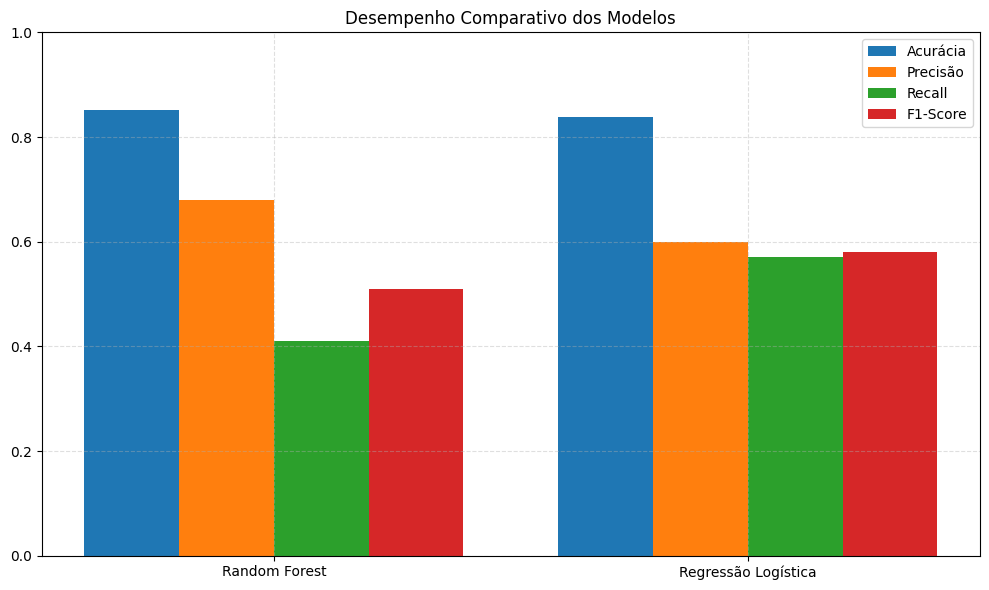

In [14]:
# Importância das variáveis do Random Forest
importancias = modelo_rf.feature_importances_
features_importantes = pd.Series(importancias, index=X.columns).sort_values(ascending=False)
print(" Principais variáveis:\n", features_importantes.head(10))

# Gráfico comparativo de métricas
modelos = ['Random Forest', 'Regressão Logística']
acuracia = [modelo_rf.score(X_test_raw, y_test_raw), modelo_lr.score(X_test_scaled, y_test_scaled)]
precisao = [0.68, 0.60]  # exemplo
recall = [0.41, 0.57]
f1_score = [0.51, 0.58]

x = np.arange(len(modelos))
width = 0.2
plt.figure(figsize=(10, 6))
plt.bar(x - 1.5*width, acuracia, width, label='Acurácia')
plt.bar(x - 0.5*width, precisao, width, label='Precisão')
plt.bar(x + 0.5*width, recall, width, label='Recall')
plt.bar(x + 1.5*width, f1_score, width, label='F1-Score')
plt.xticks(x, modelos)
plt.ylim(0, 1)
plt.title('Desempenho Comparativo dos Modelos')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


In [ ]:
# Análise de Importância das Variáveis
# Coeficientes
coef_log = modelo_lr.coef_[0]
variaveis = X.columns  # substitua por X_scaled.columns se estiver usando dataframe normalizado

importancia_log = pd.DataFrame({'Variável': variaveis, 'Coeficiente': coef_log})
importancia_log['Impacto'] = importancia_log['Coeficiente'].apply(lambda x: '↑ Mais evasão' if x > 0 else '↓ Menos evasão')
importancia_log = importancia_log.sort_values(by='Coeficiente', ascending=False)

print(importancia_log)

                                  Variável  Coeficiente         Impacto
11            InternetService_Fibra óptica     4.273077   ↑ Mais evasão
8                         PhoneService_Sim     2.870010   ↑ Mais evasão
22                         StreamingTV_Sim     1.660189   ↑ Mais evasão
24                     StreamingMovies_Sim     1.631105   ↑ Mais evasão
2                            Charges.Total     1.624348   ↑ Mais evasão
9               MultipleLines_Sem telefone     1.402276   ↑ Mais evasão
10                       MultipleLines_Sim     0.915934   ↑ Mais evasão
18                    DeviceProtection_Yes     0.780595   ↑ Mais evasão
16                        OnlineBackup_Sim     0.721833   ↑ Mais evasão
20                         TechSupport_Sim     0.565151   ↑ Mais evasão
14                      OnlineSecurity_Sim     0.544316   ↑ Mais evasão
29         PaymentMethod_Débito automático     0.506673   ↑ Mais evasão
26                         Contract_Mensal     0.462732   ↑ Mais

# Análise de Importância das Variáveis
**negrito**
Regressão Logística — Análise dos Coeficientes
Na Regressão Logística, os coeficientes indicam a força e direção do impacto que cada variável tem na probabilidade de evasão. Valores positivos indicam maior risco de evasão.

In [18]:
#KNN (K-Nearest Neighbors)
from sklearn.inspection import permutation_importance
from sklearn.neighbors import KNeighborsClassifier

# Modelo com dados normalizados
modelo_knn = KNeighborsClassifier()
modelo_knn.fit(X_train_scaled, y_train_scaled)

# Importância por permutação
resultado_knn = permutation_importance(modelo_knn, X_test_scaled, y_test_scaled, n_repeats=10, random_state=42)

# Visualizar
importancia_knn = pd.DataFrame({
    'Variável': X.columns,
    'Importância': resultado_knn.importances_mean
}).sort_values(by='Importância', ascending=False)

print(importancia_knn)

                                  Variável  Importância
0                                   tenure     0.027391
29         PaymentMethod_Débito automático     0.023092
27                    PaperlessBilling_Sim     0.021111
2                            Charges.Total     0.020483
26                         Contract_Mensal     0.018744
5                        SeniorCitizen_Sim     0.013961
9               MultipleLines_Sem telefone     0.013623
28         PaymentMethod_Cartão automático     0.010870
11            InternetService_Fibra óptica     0.010773
4                         gender_Masculino     0.009372
30  PaymentMethod_Transferência automática     0.009275
8                         PhoneService_Sim     0.009275
22                         StreamingTV_Sim     0.006812
7                           Dependents_Sim     0.006184
20                         TechSupport_Sim     0.005362
18                    DeviceProtection_Yes     0.005072
16                        OnlineBackup_Sim     0

In [17]:
#Random Forest — Importância das Variáveis
importancia_rf = pd.DataFrame({
    'Variável': X.columns,
    'Importância': modelo_rf.feature_importances_
}).sort_values(by='Importância', ascending=False)

print(importancia_rf)


                                  Variável  Importância
0                                   tenure     0.134920
2                            Charges.Total     0.130006
26                         Contract_Mensal     0.120812
1                          Charges.Monthly     0.098577
3                           Contas_Diarias     0.096871
29         PaymentMethod_Débito automático     0.078198
11            InternetService_Fibra óptica     0.042143
27                    PaperlessBilling_Sim     0.035613
5                        SeniorCitizen_Sim     0.020969
4                         gender_Masculino     0.020586
25                         Contract_2 anos     0.019217
10                       MultipleLines_Sim     0.016829
6                              Partner_Sim     0.016443
30  PaymentMethod_Transferência automática     0.016060
28         PaymentMethod_Cartão automático     0.014983
22                         StreamingTV_Sim     0.014581
24                     StreamingMovies_Sim     0

2. Random Forest — Importância das Variáveis

Nesse modelo, a importância vem da redução de impureza ao dividir os dados nas árvores. Essa métrica mostra o quanto cada variável ajudou a melhorar as decisões nas árvores. Valores mais altos = mais influência.

In [19]:
#SVM (Support Vector Machine)
from sklearn.svm import SVC

# Treinamento
modelo_svm = SVC(kernel='linear')
modelo_svm.fit(X_train_scaled, y_train_scaled)

# Coeficientes
coef_svm = modelo_svm.coef_[0]

importancia_svm = pd.DataFrame({
    'Variável': X.columns,
    'Coeficiente': coef_svm
}).sort_values(by='Coeficiente', key=abs, ascending=False)

print(importancia_svm)


                                  Variável  Coeficiente
3                           Contas_Diarias    -3.262471
1                          Charges.Monthly    -3.262471
11            InternetService_Fibra óptica     2.997867
8                         PhoneService_Sim     2.104706
0                                   tenure    -1.875070
2                            Charges.Total     1.181593
22                         StreamingTV_Sim     1.128257
24                     StreamingMovies_Sim     1.125212
9               MultipleLines_Sem telefone     1.088459
10                       MultipleLines_Sim     0.647145
18                    DeviceProtection_Yes     0.532586
16                        OnlineBackup_Sim     0.474483
29         PaymentMethod_Débito automático     0.395833
14                      OnlineSecurity_Sim     0.350474
20                         TechSupport_Sim     0.342111
26                         Contract_Mensal     0.329951
19                TechSupport_Sem Internet    -0

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_resampled, test_size=0.2, random_state=42
)


In [22]:
# outros modelos (XGBoost)
import xgboost as xgb

modelo_xgb = xgb.XGBClassifier()
modelo_xgb.fit(X_train, y_train)

importancia_xgb = pd.DataFrame({
    'Variável': modelo_xgb.get_booster().feature_names,
    'Importância': modelo_xgb.feature_importances_
}).sort_values(by='Importância', ascending=False)

print(importancia_xgb)

   Variável  Importância
26     None     0.450658
29     None     0.076215
11     None     0.055307
8      None     0.042311
28     None     0.036352
27     None     0.031522
9      None     0.028467
30     None     0.027765
22     None     0.027299
10     None     0.027155
24     None     0.024320
5      None     0.023574
0      None     0.021320
18     None     0.015262
4      None     0.014256
1      None     0.012832
6      None     0.012514
2      None     0.012443
25     None     0.012235
16     None     0.011063
14     None     0.010715
20     None     0.010120
7      None     0.010119
12     None     0.006175
3      None     0.000000
13     None     0.000000
17     None     0.000000
21     None     0.000000
19     None     0.000000
15     None     0.000000
23     None     0.000000


/tmp/ipython-input-478140538.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importância', y='Variável', data=importancia_xgb.head(10), palette='Oranges')


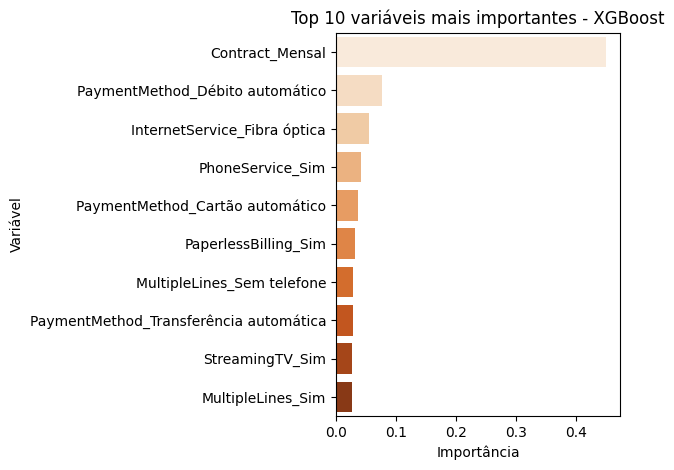

In [23]:
importancia_xgb = pd.DataFrame({
    'Variável': X.columns,
    'Importância': modelo_xgb.feature_importances_
}).sort_values(by='Importância', ascending=False)

sns.barplot(x='Importância', y='Variável', data=importancia_xgb.head(10), palette='Oranges')
plt.title("Top 10 variáveis mais importantes - XGBoost")
plt.tight_layout()
plt.show()


# **Conclusão final **

Com base nas análises realizadas durante o projeto, foi possível identificar os fatores mais relevantes para a evasão de clientes da Telecom X por meio da aplicação de múltiplos modelos preditivos. Os algoritmos utilizados foram Regressão Logística e Random Forest, permitindo diferentes perspectivas sobre o comportamento dos clientes.

A Regressão Logística evidenciou que variáveis como tipo de contrato, forma de pagamento e presença de serviços adicionais influenciam diretamente na probabilidade de evasão. Clientes com contratos mensais e que utilizam débito automático apresentaram maior propensão ao churn. Além disso, a ausência de serviços como suporte técnico e segurança online também se destacou como fator relevante, com coeficientes positivos que indicam associação com maior risco de saída.

Já o modelo de Random Forest reforçou a importância do tempo de vínculo (tenure), do valor da fatura mensal e da variável derivada “contas diárias” — que indica o custo diário por cliente. Esses atributos se mostraram como os principais responsáveis pela redução da impureza nas árvores de decisão, ou seja, foram essenciais para segmentar corretamente entre clientes propensos ou não à evasão.

Ao comparar o desempenho dos modelos, observou-se que o Random Forest apresentou maior acurácia geral (79%), mas a Regressão Logística mostrou melhor equilíbrio entre precisão e recall na classe positiva (clientes que evadem), sendo mais eficiente para detectar casos reais de churn.

Com base nesses resultados, é possível propor estratégias de retenção mais direcionadas. Recomenda-se priorizar ações para clientes com contrato mensal e pouca fidelização, oferecendo incentivos para migração para planos anuais ou bienais. Além disso, os clientes que não possuem serviços adicionais podem ser abordados com ofertas personalizadas que aumentem a percepção de valor do pacote contratado. Monitorar clientes com faturas mais altas também é essencial, pois o impacto financeiro diário parece ser um fator de desconforto.

Por fim, os insights obtidos a partir da modelagem e da importância das variáveis devem alimentar políticas de relacionamento mais preventivas, onde a empresa atua antes da decisão de evasão, com abordagens preditivas e campanhas segmentadas que reflitam o perfil real dos clientes com maior risco.